In [40]:
import pandas as pd
from os import listdir
import numpy as np
import random
import scipy.optimize as opt
import warnings
warnings.filterwarnings("ignore")

# Data

In [41]:
mypath = "Final"
data_list = listdir(mypath)

In [42]:
data = pd.DataFrame()
for col in data_list:
    tmp = pd.read_csv('Final/'+col, index_col = 'Date')
    data = pd.concat([data,tmp])
data.index = pd.DatetimeIndex(data.index)
df = pd.DataFrame(data.sort_index()['3 Mo'].copy())

In [43]:
df['3 Mo_shift'] = df['3 Mo'].shift(1) 
df['diff'] = df['3 Mo'] - df['3 Mo_shift']

In [44]:
db = df.dropna().copy()

# 估參數：k, theta , sigma

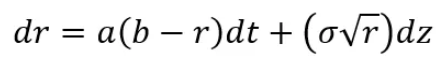

In [45]:
global N
N = 252
dt = 1/N
def fun_MLE(x): 
    
    random.seed(108)
    np.random.seed(108)
    # scipy
    DF = db_tmp.to_numpy()
    
    r0 = DF[:,0]
    r1 = DF[:,1]
    dr = DF[:,2]

    mu, sigma = 0, dt # mean and standard deviation
    s = np.random.normal(mu, sigma, len(DF))
    a = x[0]
    b = x[1]
    sigma = x[2]
    fit_dr =  a*(b-r0)*dt + sigma*np.sqrt(r0)*s
    error = np.sum(np.abs(fit_dr-dr))
    target = -np.log(error)
    # target = -error
    return target

In [46]:
initial = (0.3,0.3,0.3)
tmp = 5
constraints = ( {'type':'ineq','fun':lambda x : 2*x[0]*x[1]-x[2]**2},
                {'type':'ineq','fun':lambda x : x[2]},
                {'type':'ineq','fun':lambda x : -x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[2]+1*tmp},
                {'type':'ineq','fun':lambda x : x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : x[2]+1*tmp},
                )
# parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
# bp = parameters['x']

# CIR

In [47]:
from CIR import CIR
import matplotlib.pyplot as plt

def estimate(bp,r0, period = 2):
    # assume mean-reverted speed = 1, mean-reverted level = 0.05, vol of interest rate = 0.05, initial interest rate = 0.05, and pass to an object named C
    # print(bp[0], bp[1],bp[2])
    C = CIR(bp[0],bp[1],bp[2],r0) 
    # C = CIR(1,0.05,0.05,0.05)
    # For Euler method
    r = C.Euler(0,dt*2,dt)[-1:] # start time = 0, end time = 1, dt = 0.01
    # print(r)
    # For Milstern method
    r1 = C.Milstein(0,dt*2,dt)[-1:]
    # Plot and compare
    # plt.figure(figsize=(20,10))
    # l1,=plt.plot(r)
    # l2,=plt.plot(r1,'b*',markersize=4)
    # plt.ylabel('interest rate r',fontsize = 20)
    # plt.legend(handles=[l1, l2], labels=['Euler', 'Milstein'], fontsize = 16)
    return r,r1



# Rolling CIR

In [48]:
ROLLING = 30 #調整參數週期
dates = db[::ROLLING].index
period = 2 # 預測下一期
global db_tmp

In [49]:
bps = []
for i in range(1,len(dates)):
    db_tmp = db[((db.index < dates[i]) & (db.index >= dates[i-1]))]
    parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
    bp = parameters['x']
    bps.append(bp)
     

In [50]:
df_pa = pd.DataFrame(bps, columns = ['a','b','sigma'],index = dates[1:])
df_pa_me =  pd.merge(df, df_pa, left_on = 'Date', right_on = 'Date',how = 'outer').ffill()
DB = df_pa_me.dropna()


In [51]:
estimates_1 = []
estimates_2 = []
for i in range(0,len(DB)):
    estimate_1, estimate_2 = estimate((DB['a'][i],DB['b'][i], DB['sigma'][i]),DB['3 Mo_shift'][i], period = 2)
    estimates_1.append(estimate_1[0])
    estimates_2.append(estimate_2[0])
DB['pred_1'] = estimates_1 
DB['pred_2'] = estimates_2

Text(0.5, 1.0, 'Rolling CIR')

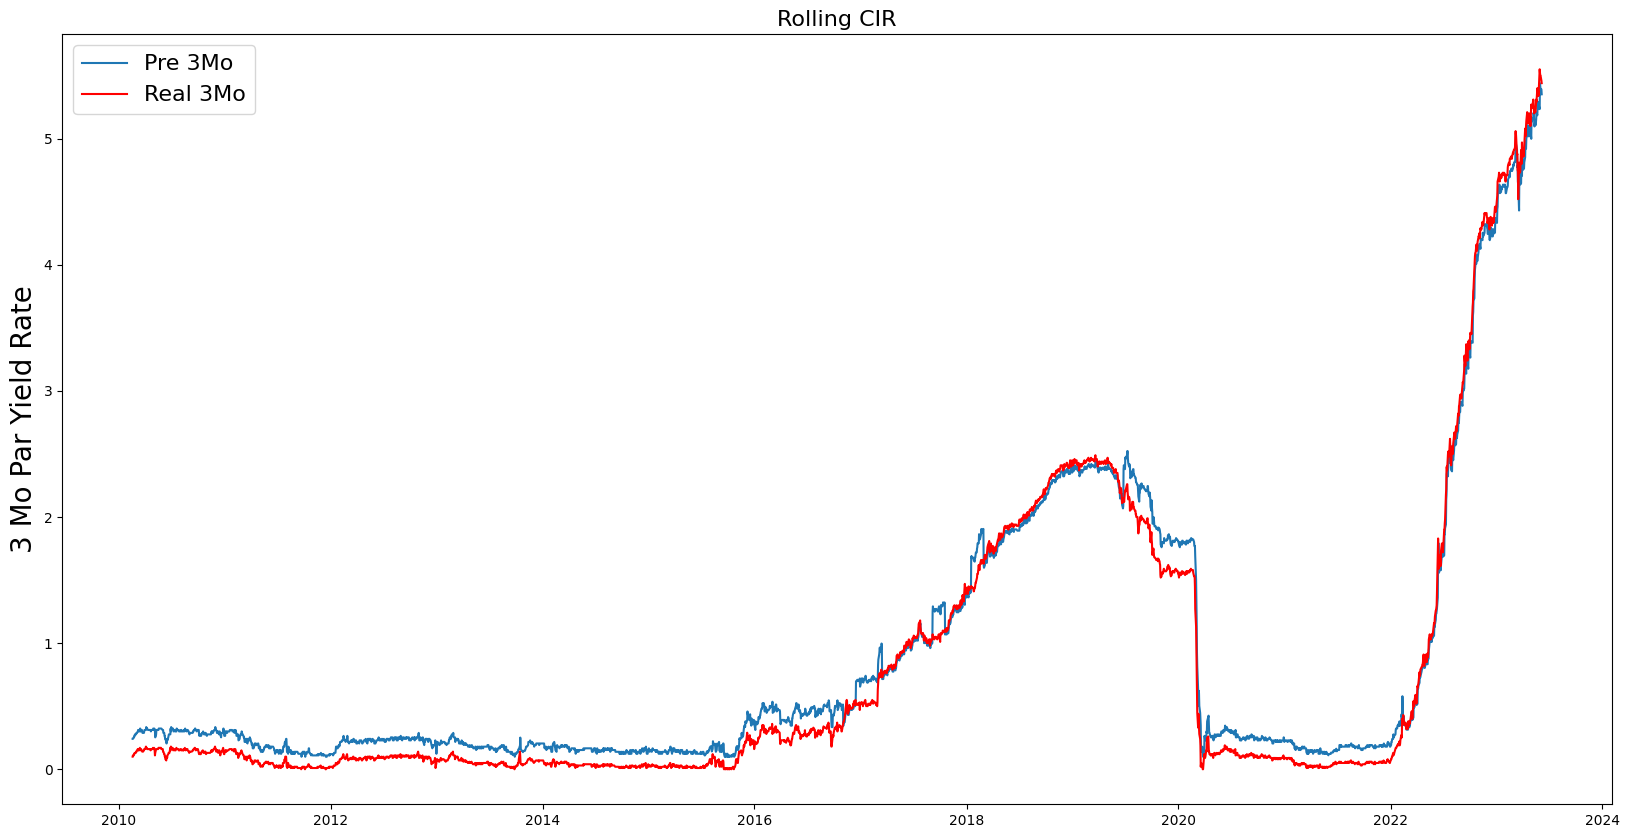

In [52]:
plt.figure(figsize=(20,10))
l1,= plt.plot(DB['pred_1'])
# l2,= plt.plot(DB['pred_2'],'b-',markersize=4)
l3, = plt.plot(DB['3 Mo'],'r-',markersize=4)
plt.ylabel('3 Mo Par Yield Rate',fontsize = 20)
plt.legend(handles=[l1, l3], labels=['Pre 3Mo', 'Real 3Mo'], fontsize = 16)
plt.title('Rolling CIR', fontsize = 16)

# Error Calculated : RMSE MSE SSE

In [53]:
DB

,3 Mo,3 Mo_shift,diff,a,b,sigma,pred_1,pred_2
Date,,,,,,,,
2010-02-18,0.10,0.10,0.00,5.0,5.000000e+00,5.000000e+00,0.241170,0.201223
2010-02-19,0.11,0.10,0.01,5.0,5.000000e+00,5.000000e+00,0.241170,0.201223
2010-02-22,0.11,0.11,0.00,5.0,5.000000e+00,5.000000e+00,0.253116,0.213170
2010-02-23,0.12,0.11,0.01,5.0,5.000000e+00,5.000000e+00,0.253116,0.213170
2010-02-24,0.12,0.12,0.00,5.0,5.000000e+00,5.000000e+00,0.264967,0.225021
...,...,...,...,...,...,...,...,...
2023-05-31,5.52,5.55,-0.03,5.0,1.522149e-14,-2.604652e-15,5.439881,5.439881
2023-06-01,5.50,5.52,-0.02,5.0,1.522149e-14,-2.604652e-15,5.410476,5.410476
2023-06-02,5.50,5.50,0.00,5.0,1.522149e-14,-2.604652e-15,5.390873,5.390873


In [54]:
# MSE
MSE = np.sum((DB['pred_1'] - DB['3 Mo'])**2)/len(DB)

# RMSE
RMSE = np.sqrt(MSE)

# MAPE
MAPE = np.sum(np.abs((DB['pred_1']-DB['3 Mo'])/DB['3 Mo']))/len(DB)

In [55]:
np.sum(np.abs((DB['pred_1']-DB['3 Mo'])/DB['3 Mo']))

inf

In [56]:
tmp = np.abs((DB['pred_1']-DB['3 Mo'])/DB['3 Mo'])

In [57]:
MSE

0.018616380642869534

In [58]:
MAPE

inf

# Vacisek